In [54]:

from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
sns.set()

In [56]:
df['sentiment'] = ['pos' if (x>3) else 'neg' for x in df['stars']]

In [55]:

df = pd.read_csv("review.csv", sep=",", low_memory=False, nrows=50000)

In [57]:
df.head()

,cool,business_id,funny,user_id,stars,text,review_id,date,useful,sentiment
0,0,iCQpiavjjPzJ5_3gPD5Ebg,0,msQe1u7Z_XuqjGoqhB0J5g,2,The pizza was okay. Not the best I've had. I p...,x7mDIiDB3jEiPGPHOmDzyw,2011-02-25,0,neg
1,0,pomGBqfbxcqPv14c3XH-ZQ,0,msQe1u7Z_XuqjGoqhB0J5g,5,I love this place! My fiance And I go here atl...,dDl8zu1vWPdKGihJrwQbpw,2012-11-13,0,pos
2,1,jtQARsP6P-LbkyjbO1qNGg,1,msQe1u7Z_XuqjGoqhB0J5g,1,Terrible. Dry corn bread. Rib tips were all fa...,LZp4UX5zK3e-c5ZGSeo3kA,2014-10-23,3,neg
3,0,elqbBhBfElMNSrjFqW3now,0,msQe1u7Z_XuqjGoqhB0J5g,2,Back in 2005-2007 this place was my FAVORITE t...,Er4NBWCmCD4nM8_p1GRdow,2011-02-25,2,neg
4,0,Ums3gaP2qM3W1XcA5r6SsQ,0,msQe1u7Z_XuqjGoqhB0J5g,5,Delicious healthy food. The steak is amazing. ...,jsDu6QEJHbwP2Blom1PLCA,2014-09-05,0,pos


In [58]:
df['review_length'] = df.text.map(len)

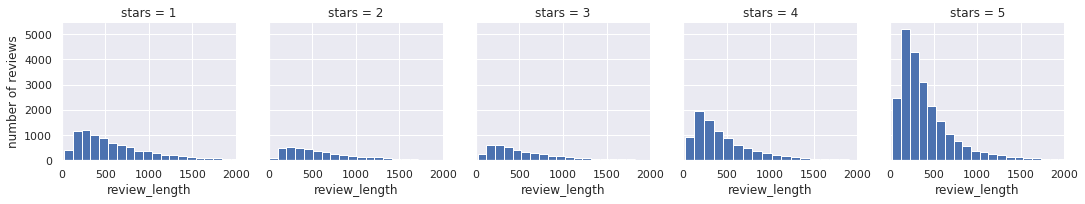

In [59]:
ax = sns.FacetGrid(data=df, col='stars', xlim=(0, 2000)).map(plt.hist, 'review_length', bins=50)
ax.axes[0][0].set(ylabel='number of reviews');

In [60]:
df['text'] = df['text'].astype('str')

In [61]:
pos_reviews = df.text[df.stars>3].values
neg_reviews = df.text[df.stars<3].values
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  32,384
Negative Reviews:  13,345


In [62]:
from sklearn.feature_extraction import text 
extra_words = ['ve', 'like', 'got', 'Cleveland', 'just', 
               'don', 'really', 'said', 'told', 'ok',
               'came', 'went', 'did', 'didn', 'good']
stop_words = text.ENGLISH_STOP_WORDS.union(extra_words)

In [63]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 20000
random_neg = np.random.choice(neg_reviews, size=num_reviews)
random_pos = np.random.choice(pos_reviews, size=num_reviews)

dicty = {'pizzas':'pizza', 'burgers':'burger', 'ordered':'order',
         'prices':'price', 'topping':'toppings'}
def replace_words(text, dicty):
    '''Returns text with word substitutions made according
       to the passed `dicty` dictionary'''
    for i,j in dicty.items():
        text = text.replace(i,j)
    return text

random_neg = [replace_words(w, dicty) for w in random_neg]
random_pos = [replace_words(w, dicty) for w in random_pos]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(random_neg)
pos_vectors = tfidf_pos.fit_transform(random_pos)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cleveland'] not in stop_words.
  sorted(inconsistent))


CPU times: user 3.62 s, sys: 164 ms, total: 3.78 s
Wall time: 3.78 s


In [64]:
# Store TFIDF vectors in a Pandas DataFrame to investigate further
neg_df = pd.DataFrame(neg_vectors.todense(), columns=[tfidf_neg.get_feature_names()])
pos_df = pd.DataFrame(pos_vectors.todense(), columns=[tfidf_pos.get_feature_names()])

# get mean for each column (word): highest means are most important words
col_means_neg = {}
for col in neg_df:
    col_means_neg[col] = neg_df[col].mean()

col_means_pos = {}
for col in pos_df:
    col_means_pos[col] = pos_df[col].mean()

In [65]:
no_top_words = 8

print('Top %d words in POSITIVE reviews:' %no_top_words, end='')
print(sorted(col_means_pos, key=col_means_pos.get, reverse=True)[:no_top_words])

print('Top %d words in NEGATIVE reviews:' %no_top_words, end='')
print(sorted(col_means_neg, key=col_means_neg.get, reverse=True)[:no_top_words])

Top 8 words in POSITIVE reviews:[('great',), ('food',), ('place',), ('service',), ('best',), ('time',), ('friendly',), ('love',)]
Top 8 words in NEGATIVE reviews:[('food',), ('service',), ('place',), ('order',), ('time',), ('minutes',), ('people',), ('bad',)]


In [66]:
del neg_df
del pos_df

In [67]:
# LSA
from gensim import corpora, models, similarities, matutils


tfidf_pos_corpus = matutils.Sparse2Corpus(pos_vectors.transpose())
tfidf_neg_corpus = matutils.Sparse2Corpus(neg_vectors.transpose())

# Row indices
id2word_pos = dict((v,k) for k,v in tfidf_pos.vocabulary_.items())
id2word_neg = dict((v,k) for k,v in tfidf_neg.vocabulary_.items())


id2word_pos = corpora.Dictionary.from_corpus(tfidf_pos_corpus, id2word=id2word_pos)
id2word_neg = corpora.Dictionary.from_corpus(tfidf_neg_corpus, id2word=id2word_neg)

In [68]:
num_topics = 20
lsi_pos = models.LsiModel(tfidf_pos_corpus, id2word=id2word_pos, num_topics=num_topics)
lsi_neg = models.LsiModel(tfidf_neg_corpus, id2word=id2word_neg, num_topics=num_topics)

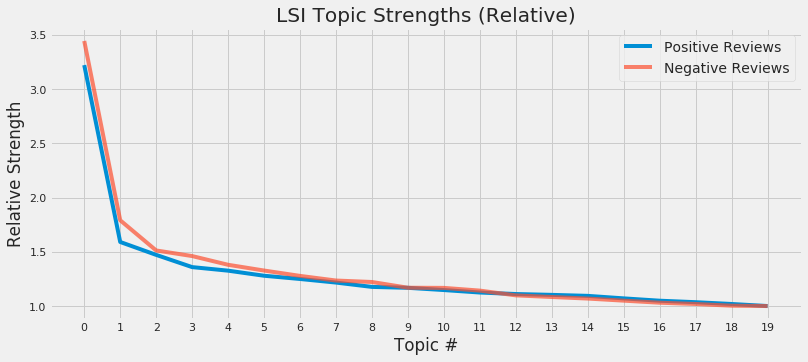

In [69]:
singular_values_pos = lsi_pos.projection.s.tolist()
singular_values_pos_rel = [sv/singular_values_pos[-1] for sv in singular_values_pos]
singular_values_neg = lsi_neg.projection.s.tolist()
singular_values_neg_rel = [sv/singular_values_neg[-1] for sv in singular_values_neg]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
plt.plot(range(len(singular_values_pos)), singular_values_pos_rel, label='Positive Reviews', alpha=1.0)
plt.plot(range(len(singular_values_neg)), singular_values_neg_rel, label='Negative Reviews', alpha=0.7)
plt.xticks(range(len(singular_values_pos)), range(len(singular_values_pos)))
plt.xlabel('Topic #')
plt.ylabel('Relative Strength')
plt.title('LSI Topic Strengths (Relative)')
plt.legend(loc=0, fontsize='medium');


In [70]:
topics_to_print = 5
print('Top %d topics for POSITIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_pos.show_topics()[0:topics_to_print])

Top 5 topics for POSITIVE reviews
---------------------------------
[(0,
  '0.308*"great" + 0.283*"food" + 0.254*"place" + 0.212*"service" + '
  '0.147*"friendly" + 0.145*"time" + 0.138*"love" + 0.138*"best" + '
  '0.136*"staff" + 0.126*"amazing"'),
 (1,
  '-0.337*"food" + -0.179*"chicken" + -0.168*"delicious" + 0.167*"hair" + '
  '0.167*"job" + 0.160*"recommend" + 0.155*"work" + -0.139*"order" + '
  '0.138*"time" + 0.131*"professional"'),
 (2,
  '-0.509*"great" + -0.354*"food" + -0.350*"service" + 0.242*"pizza" + '
  '0.151*"order" + -0.106*"excellent" + -0.105*"friendly" + 0.103*"best" + '
  '0.099*"time" + 0.093*"chicken"'),
 (3,
  '0.769*"pizza" + 0.229*"place" + 0.228*"great" + 0.202*"love" + '
  '-0.132*"food" + 0.107*"staff" + -0.101*"chicken" + -0.093*"restaurant" + '
  '-0.086*"xc" + 0.083*"friendly"'),
 (4,
  '-0.446*"pizza" + 0.438*"place" + 0.400*"love" + -0.315*"service" + '
  '0.222*"staff" + -0.152*"excellent" + -0.148*"xc" + 0.142*"friendly" + '
  '-0.127*"customer" + 0

In [71]:
print('Top %d topics for NEGATIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_neg.show_topics()[0:topics_to_print])

Top 5 topics for NEGATIVE reviews
---------------------------------
[(0,
  '0.277*"food" + 0.209*"order" + 0.204*"service" + 0.189*"place" + '
  '0.170*"time" + 0.129*"minutes" + 0.104*"restaurant" + 0.098*"asked" + '
  '0.096*"bad" + 0.094*"people"'),
 (1,
  '-0.410*"food" + 0.257*"car" + -0.203*"order" + -0.163*"chicken" + '
  '0.141*"called" + 0.132*"customer" + 0.116*"company" + 0.115*"appointment" + '
  '-0.114*"restaurant" + 0.106*"room"'),
 (2,
  '0.791*"pizza" + -0.326*"food" + 0.224*"order" + -0.204*"service" + '
  '0.106*"cheese" + 0.100*"sauce" + 0.086*"crust" + 0.068*"delivery" + '
  '0.067*"wings" + 0.064*"called"'),
 (3,
  '0.367*"minutes" + 0.274*"order" + -0.204*"place" + 0.174*"table" + '
  '0.172*"waited" + 0.161*"service" + -0.161*"chicken" + -0.147*"price" + '
  '0.146*"wait" + -0.129*"burger"'),
 (4,
  '-0.419*"pizza" + -0.403*"service" + -0.294*"food" + 0.206*"order" + '
  '-0.205*"customer" + 0.176*"burger" + 0.156*"chicken" + 0.147*"minutes" + '
  '-0.144*"place

In [72]:
%%time

from sklearn.decomposition import NMF


num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

CPU times: user 5.08 s, sys: 156 ms, total: 5.24 s
Wall time: 4.68 s


In [73]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 6

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.028*order, 0.978*chicken, 0.878*delicious, 0.846*food, 0.688*restaurant, 0.629*try
Topic 1:   0.770*time, 0.615*recommend, 0.547*work, 0.509*job, 0.499*hair, 0.462*highly
Topic 2:   2.257*place, 1.565*love, 1.078*staff, 0.915*friendly, 0.681*nice, 0.463*clean
Topic 3:   2.917*pizza, 0.306*crust, 0.271*best, 0.195*cheese, 0.183*wings, 0.169*order
Topic 4:   2.963*great, 2.151*food, 2.124*service, 0.708*excellent, 0.510*atmosphere, 0.409*price
Topic 5:   2.199*xc, 1.695*xa, 0.309*et, 0.273*le, 0.231*est, 0.212*und

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.243*chicken, 0.920*burger, 0.671*order, 0.581*fries, 0.564*sauce, 0.561*rice
Topic 1:   0.560*time, 0.541*customer, 0.505*room, 0.478*called, 0.443*service, 0.416*place
Topic 2:   2.868*pizza, 0.344*order, 0.296*crust, 0.269*cheese, 0.249*sauce, 0.226*delivery
Topic 3:   1.286*order, 1.224*minu

In [74]:
review_num = np.random.randint(0, high=len(random_pos))
print(review_num)
print(random_pos[review_num])

4065
A Great Culinary Experience!\n\nI never write reviews.  I mean, ever.  But I feel that these guys deserve a review, no, they deserve praise!\n\nThe food was exquisite and the service was superb.  Imagine a small sandwich shop with four star food and service couple with a hip atmosphere. Truly an experience you have to see for yourself.\n\nI had a sandwich called "miss piggy".  An appropriate name for hardy meets healthy.  I never thought healthy can be both scrumptious and filling.  I can still taste it and can\'t wait to try it again.\n\nI tell everyone I know about this truly under-rated cafe/restaurant I have ever encountered.  Somehow, I feel enriched by the experience.\n\nTHIS IS A MUST EXPERIENCE.  Take your friends, family and business associates for I guarantee all will enjoy!


In [75]:
import sklearn.metrics.pairwise as smp

cosines = {}
for ind, review in enumerate(W_pos):
    similarity = smp.cosine_similarity(W_pos[review_num].reshape(1,-1), review.reshape(1,-1))
    cosines[ind] = similarity[0][0]

In [76]:
for n in sorted(cosines, key=cosines.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines[n]))
    print(random_pos[n])
print('-'*50)

--------------------------------------------------
>> Similarity 1.000
A Great Culinary Experience!\n\nI never write reviews.  I mean, ever.  But I feel that these guys deserve a review, no, they deserve praise!\n\nThe food was exquisite and the service was superb.  Imagine a small sandwich shop with four star food and service couple with a hip atmosphere. Truly an experience you have to see for yourself.\n\nI had a sandwich called "miss piggy".  An appropriate name for hardy meets healthy.  I never thought healthy can be both scrumptious and filling.  I can still taste it and can\'t wait to try it again.\n\nI tell everyone I know about this truly under-rated cafe/restaurant I have ever encountered.  Somehow, I feel enriched by the experience.\n\nTHIS IS A MUST EXPERIENCE.  Take your friends, family and business associates for I guarantee all will enjoy!
--------------------------------------------------
>> Similarity 1.000
This use to be my stomping grounds when I lived in Calgary & I

In [77]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts
cv_pos = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

cv_neg = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 15000
cv_random_neg = np.random.choice(neg_reviews, size=num_reviews)
cv_random_pos = np.random.choice(pos_reviews, size=num_reviews)

# replace words from defined dictionary 'dicty'
cv_random_neg = [replace_words(w, dicty) for w in cv_random_neg]
cv_random_pos = [replace_words(w, dicty) for w in cv_random_pos]

# Get the cv vectors
cv_neg_vectors = cv_neg.fit_transform(cv_random_neg).transpose()
cv_pos_vectors = cv_pos.fit_transform(cv_random_pos).transpose()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cleveland'] not in stop_words.
  sorted(inconsistent))


In [78]:
corpus_neg = matutils.Sparse2Corpus(cv_neg_vectors)
corpus_pos = matutils.Sparse2Corpus(cv_pos_vectors)

# save a mapping (dict) of row id to word (token) for later use by gensim 
id2word_cv_pos = dict((v, k) for k, v in cv_pos.vocabulary_.items())
id2word_cv_neg = dict((v, k) for k, v in cv_neg.vocabulary_.items())

In [79]:
print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.028*order, 0.978*chicken, 0.878*delicious, 0.846*food, 0.688*restaurant, 0.629*try
Topic 1:   0.770*time, 0.615*recommend, 0.547*work, 0.509*job, 0.499*hair, 0.462*highly
Topic 2:   2.257*place, 1.565*love, 1.078*staff, 0.915*friendly, 0.681*nice, 0.463*clean
Topic 3:   2.917*pizza, 0.306*crust, 0.271*best, 0.195*cheese, 0.183*wings, 0.169*order
Topic 4:   2.963*great, 2.151*food, 2.124*service, 0.708*excellent, 0.510*atmosphere, 0.409*price
Topic 5:   2.199*xc, 1.695*xa, 0.309*et, 0.273*le, 0.231*est, 0.212*und


In [80]:
review_num = np.random.randint(0, high=len(random_pos))
print('Positive Review #%d' %review_num)
print('-'*25)
print(random_pos[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_pos[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Positive Review #8764
-------------------------
Great breakfast place, it's busy but the owner always makes sure to grab your name if there's a lineup\n\nMenu is great, I always take the Incredible, yum!!
-------------------------
Topic 4: 0.0305
Topic 2: 0.0281
Topic 0: 0.0025
Topic 1: 0.0024
Topic 3: 0.0003
Topic 5: 0.0000


In [81]:
print('Top topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.243*chicken, 0.920*burger, 0.671*order, 0.581*fries, 0.564*sauce, 0.561*rice
Topic 1:   0.560*time, 0.541*customer, 0.505*room, 0.478*called, 0.443*service, 0.416*place
Topic 2:   2.868*pizza, 0.344*order, 0.296*crust, 0.269*cheese, 0.249*sauce, 0.226*delivery
Topic 3:   1.286*order, 1.224*minutes, 0.822*table, 0.563*wait, 0.563*server, 0.554*waited
Topic 4:   2.798*food, 1.318*service, 0.780*place, 0.488*bad, 0.452*worst, 0.421*terrible
Topic 5:   2.516*car, 0.354*oil, 0.351*wash, 0.264*vehicle, 0.254*dealership, 0.224*change


In [82]:
review_num = np.random.randint(0, high=len(random_neg))
print('Negative Review #%d' %review_num)
print('-'*25)
print(random_neg[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_neg[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Negative Review #4602
-------------------------
Noticed the pub had a sign out for breakfast so we were excited to go try it. Thank goodness that we met some great friends otherwise the 75 minutes that we were there, would have been excruciating. I finally flagged down wait staff for a menu after sitting there for 15 minutes or more. Once drinks arrived, we were actually getting our own coffee refills. When the food arrived it was cold and the delivery disorganized. We wanted to leave long before the food arrived but felt trapped as the order had already been placed. Food arrived over an hour after we initially sat down when one of our party went and asked about the food. We watched 4 tables empty prior to getting food or drink due to lack of attention from the wait staff. The receipt was long and only noted meat and eggs so there was no way to determine that what we order VS what was delivered had been properly charged. At that point, we just paid the bill in order to gain freedom.
--

In [83]:
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  32,384
Negative Reviews:  13,345


In [84]:
%%time
# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# replace words with defined dictionary 'dicty'
pos_reviews = [replace_words(w, dicty) for w in pos_reviews]
neg_reviews = [replace_words(w, dicty) for w in neg_reviews]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(neg_reviews)
pos_vectors = tfidf_pos.fit_transform(pos_reviews)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cleveland'] not in stop_words.
  sorted(inconsistent))


CPU times: user 3.69 s, sys: 83.1 ms, total: 3.78 s
Wall time: 3.78 s


In [85]:
%%time
# NMF for all reviews
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

CPU times: user 4.23 s, sys: 146 ms, total: 4.37 s
Wall time: 3.77 s


In [86]:
no_topics = num_topics
no_top_words = 6

print('Topics for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTopics for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Topics for POSITIVE reviews
---------------------------------------
Topic 0:   1.076*order, 1.006*chicken, 0.947*delicious, 0.869*food, 0.744*restaurant, 0.683*burger
Topic 1:   0.826*time, 0.690*recommend, 0.595*work, 0.550*job, 0.523*hair, 0.514*highly
Topic 2:   2.446*great, 1.824*food, 1.640*service, 0.514*excellent, 0.418*price, 0.418*atmosphere
Topic 3:   2.801*place, 1.941*love, 0.888*staff, 0.812*friendly, 0.591*nice, 0.461*coffee
Topic 4:   3.533*pizza, 0.432*crust, 0.275*best, 0.229*wings, 0.214*toppingss, 0.188*fresh
Topic 5:   2.421*xc, 1.847*xa, 0.366*et, 0.255*est, 0.250*la, 0.247*le

Topics for NEGATIVE reviews
---------------------------------------
Topic 0:   1.148*chicken, 0.734*burger, 0.570*place, 0.567*order, 0.517*sauce, 0.500*fries
Topic 1:   0.523*time, 0.490*customer, 0.476*room, 0.414*called, 0.393*service, 0.376*store
Topic 2:   2.648*pizza, 0.268*order, 0.268*crust, 0.237*cheese, 0.207*sauce, 0.198*delivery
Topic 3:   1.318*order, 1.204*minutes, 0.702*table,

In [87]:
pos_topics = {0:'beer/happy_hour', 1:'food/pizza', 2:'service/atmosphere', 
              3:'food/burger/fries', 4:'friendly_staff', 5:'food/chicken/salad'}

neg_topics = {0:'beer/people', 1:'food/chicken/salad', 2:'food/pizza', 
              3:'wait/table', 4:'food/burger/fries', 5:'bad_service'}

In [88]:
df_pos = df[['business_id', 'stars', 'text', 'review_length']][df.stars>3].reset_index()
df_neg = df[['business_id', 'stars', 'text', 'review_length']][df.stars<3].reset_index()
df_pos.drop(labels='index', axis=1, inplace=True)
df_neg.drop(labels='index', axis=1, inplace=True)

In [89]:
print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())

Topic weights :  [0.02765484 0.         0.02345598 0.05580814 0.00089671 0.00042043]
Sum of weights:  0.10823610500570774


In [90]:
from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_pos[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_pos[0].reshape(1,-1), norm='l1').sum())

Normalized Topic weights :  [[0.25550479 0.         0.21671124 0.51561486 0.00828477 0.00388434]]
Sum of normalized weights:  1.0


In [91]:
df_pos = pd.concat([df_pos, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
df_neg = pd.concat([df_neg, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)

In [92]:
df_neg.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,iCQpiavjjPzJ5_3gPD5Ebg,2,The pizza was okay. Not the best I've had. I p...,449,0.014072,0.086813,0.645903,0.000000,0.253211,0.000000
1,jtQARsP6P-LbkyjbO1qNGg,1,Terrible. Dry corn bread. Rib tips were all fa...,156,0.967428,0.000000,0.000000,0.000000,0.032572,0.000000
2,elqbBhBfElMNSrjFqW3now,2,Back in 2005-2007 this place was my FAVORITE t...,902,0.310268,0.322600,0.000000,0.041339,0.294566,0.031227
3,vgfcTvK81oD4r50NMjU2Ag,1,This place sucks. The customer service is horr...,470,0.000000,0.091763,0.384779,0.197041,0.326417,0.000000
4,atVh8viqTj-sqDJ35tAYVg,2,"Food is pretty good, not gonna lie. BUT you ha...",1003,0.163762,0.128699,0.093458,0.289856,0.320596,0.003629


In [93]:
df_pos_bsns = df_pos.groupby('business_id').agg({'stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()
df_neg_bsns = df_neg.groupby('business_id').agg({'stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()

In [94]:
df_pos_bsns.head(5)


,business_id,stars,text,review_length,0,1,2,3,4,5
0,--9e1ONYQuAa-CB_Rrw7Tw,4.833333,6,238.5,0.614363,0.144698,0.118758,0.085384,0.019220,0.017577
1,--Gc998IMjLn8yr-HTzGUg,5.000000,1,263.0,0.634037,0.000000,0.000000,0.326072,0.039891,0.000000
2,--Y7NhBKzLTbNliMUX_wfg,5.000000,1,1188.0,0.000000,0.934466,0.065534,0.000000,0.000000,0.000000
3,--cZ6Hhc9F7VkKXxHMVZSQ,5.000000,2,588.0,0.588463,0.057117,0.206809,0.147610,0.000000,0.000000
4,--g-a85VwrdZJNf0R95GcQ,5.000000,1,59.0,0.126264,0.000000,0.763861,0.062996,0.028951,0.017928


In [95]:
df_neg_bsns.head()


,business_id,stars,text,review_length,0,1,2,3,4,5
0,--6MefnULPED_I942VcFNA,1.0,1,331.0,0.203841,0.369877,0.013424,0.000000,0.412859,0.000000
1,--9e1ONYQuAa-CB_Rrw7Tw,2.0,1,998.0,0.355980,0.139976,0.016735,0.140092,0.277326,0.069891
2,--cjBEbXMI2obtaRHNSFrA,1.0,1,116.0,0.000000,0.517705,0.000000,0.022038,0.339497,0.120760
3,--orEUqwTzz5QKbmyYbAWw,1.0,1,201.0,0.000000,0.349686,0.023088,0.552096,0.000000,0.075129
4,-050d_XIor1NpCuWkbIVaQ,2.0,1,1727.0,0.509888,0.360285,0.015613,0.000000,0.090187,0.024028
